### Oleksiy Anokhin | (August 17, 2020)

### Starbucks App Customer Rewards Program

### MSCA 31008 | Data Mining Principles | Professor U. Pamuksuz | Team Project

**Business problem:**

Predict the time difference (the number of hours) between vieweing and completing the offer. 

Why is it important? Understanding this, we will be able to target certaing customers additionally. For example, if we can predict the time difference and some customers take much more time, we can send them one more reminder. At the same time, we will not bother other customers, who are expected to complete offer soon and annoy them with additional spam. 

Three main columns for this type of analysis:

- `viewed time` (how much hours the user spends before vieweing the offer after receiving it)
- `completed time` (how much hours the user spends before competing the offer after vieweing it)
- `time_completed_viewed` (the difference. 0 in difference means the customer completed the offer immediately after vieweing it)

**1. Data Cleaning | EDA | Feature Engineering**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as cv
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import smogn
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report 
import pycaret
from pycaret.utils import version
from pycaret.regression import *
from pycaret.classification import *
import imblearn
from collections import Counter
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

C:\Users\oleks\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
# Set additional parameters
# Remove column display limits
pd.set_option('display.max_columns', None)
# pd.set_option('display.height', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style("white")

# Create palette
starbucks_palette = ["#00704A", "#362415", "#eac784", "#604c4c"]

In [20]:
# Read clean data
starbucks = pd.read_csv('starbucks.csv')

# Drop columns
starbucks = starbucks.drop(['Unnamed: 0'], axis = 1)

# Dimensions
starbucks.shape

C:\Users\oleks\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(147508, 29)

**Important:** We can see that the total number of our transactions is almost 150000. But I am making an assumption that 0 in difference means the customer completed the offer immediately after vieweing it. As a result, I remove all rows with zeros from this dataframe, which decreases the dataframe to 17000 rows only (by more that 85%).

In [21]:
# Drop rows where completed_time = 0
starbucks = starbucks[starbucks.completed_time != 0]
starbucks = starbucks[starbucks.time_completed_viewed > 0]

# Dimensions
starbucks.shape

(17228, 29)

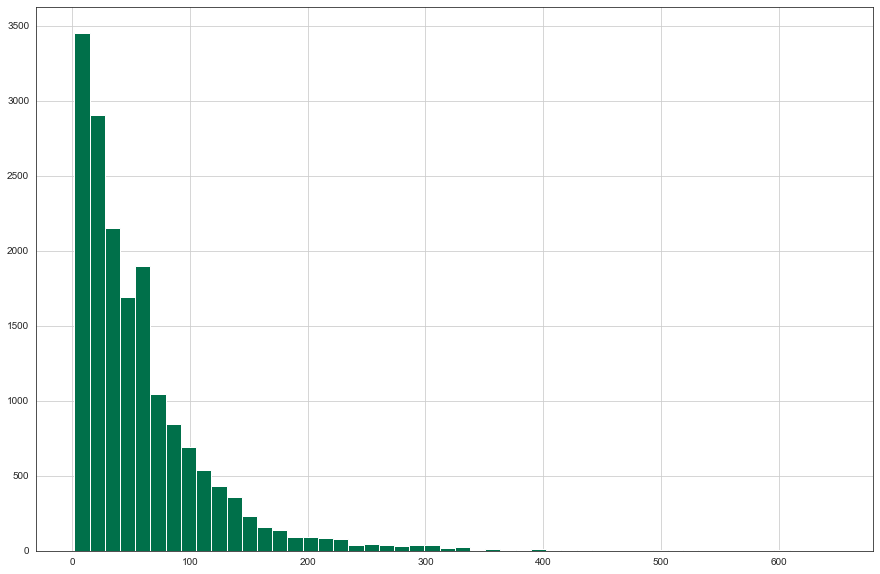

In [22]:
# Histogram of time_completed_viewed 
starbucks.time_completed_viewed.hist(bins = 50, color = '#00704A')
# As we can see, our histogram is positively skewed again. 

In [23]:
# # Log transformation of y variable

# # Create a copy
# starbucks_log = starbucks.copy()
# starbucks_log.time_completed_viewed = np.log(starbucks_log.time_completed_viewed)

In [24]:
# # Print 
# starbucks_log.head()

In [25]:
# # Check correlation 
# cor = starbucks_log.corr()
# cor.loc[:,:] = np.tril(cor, k=-1) 
# cor = cor.stack()
# cor[(cor > 0.55) | (cor < -0.55)]

In [26]:
# Select variables
starbucks = starbucks[['time_completed_viewed', 'amount', 'male', 'age', 'income', 'viewed_time',
                       'total_reward', 'membership_days', 'difficulty', 'duration', 'transaction', 'offer_viewed',
                       'offer_received', 'offer_completed']]

In [27]:
# Check correlation again
cor = starbucks.corr()
cor.loc[:,:] = np.tril(cor, k=-1) 
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

duration  difficulty    0.55802
dtype: float64

In [28]:
# Print
starbucks.head()

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed
0,54.0,16.06,0,45,62000.0,6.0,2.0,608,10.0,10.0,1.0,1.0,1,1.0
2,120.0,14.00,1,71,73000.0,273.0,4.0,268,10.0,10.0,1.0,1.0,1,1.0
5,54.0,24.41,0,87,47000.0,0.0,2.0,498,10.0,10.0,1.0,1.0,1,1.0
6,168.0,24.08,0,67,95000.0,336.0,2.0,5,10.0,10.0,1.0,1.0,1,1.0
7,60.0,28.03,0,57,118000.0,426.0,2.0,1058,10.0,10.0,1.0,1.0,1,1.0


In [29]:
# Standartize columns 
scaler = StandardScaler()
starbucks[['amount', 'income', 'age', 'viewed_time', 'total_reward', 'membership_days', 'difficulty', 
           'duration']] = scaler.fit_transform(starbucks[['amount', 'income', 'age', 'viewed_time', 'total_reward', 
                                                          'membership_days', 'difficulty', 'duration']])

In [30]:
# Print
starbucks.head()

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed
0,54.0,-0.178872,0,-0.639364,-0.310325,-1.844060,-0.880689,0.036974,0.302756,1.51035,1.0,1.0,1,1.0
2,120.0,-0.222823,1,0.912089,0.208567,-0.386243,-0.424613,-0.788151,0.302756,1.51035,1.0,1.0,1,1.0
5,54.0,-0.000723,0,1.866829,-1.017905,-1.876820,-0.880689,-0.229978,0.302756,1.51035,1.0,1.0,1,1.0
6,168.0,-0.007764,0,0.673404,1.246350,-0.042264,-0.880689,-1.426410,0.302756,1.51035,1.0,1.0,1,1.0
7,60.0,0.076510,0,0.076691,2.331306,0.449135,-0.880689,1.129052,0.302756,1.51035,1.0,1.0,1,1.0


In [31]:
# For Starbucks df
starbucks = starbucks[np.isfinite(starbucks).all(1)]
starbucks.head()

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed
0,54.0,-0.178872,0,-0.639364,-0.310325,-1.844060,-0.880689,0.036974,0.302756,1.51035,1.0,1.0,1,1.0
2,120.0,-0.222823,1,0.912089,0.208567,-0.386243,-0.424613,-0.788151,0.302756,1.51035,1.0,1.0,1,1.0
5,54.0,-0.000723,0,1.866829,-1.017905,-1.876820,-0.880689,-0.229978,0.302756,1.51035,1.0,1.0,1,1.0
6,168.0,-0.007764,0,0.673404,1.246350,-0.042264,-0.880689,-1.426410,0.302756,1.51035,1.0,1.0,1,1.0
7,60.0,0.076510,0,0.076691,2.331306,0.449135,-0.880689,1.129052,0.302756,1.51035,1.0,1.0,1,1.0


In [32]:
# Print
starbucks.shape

(17228, 14)

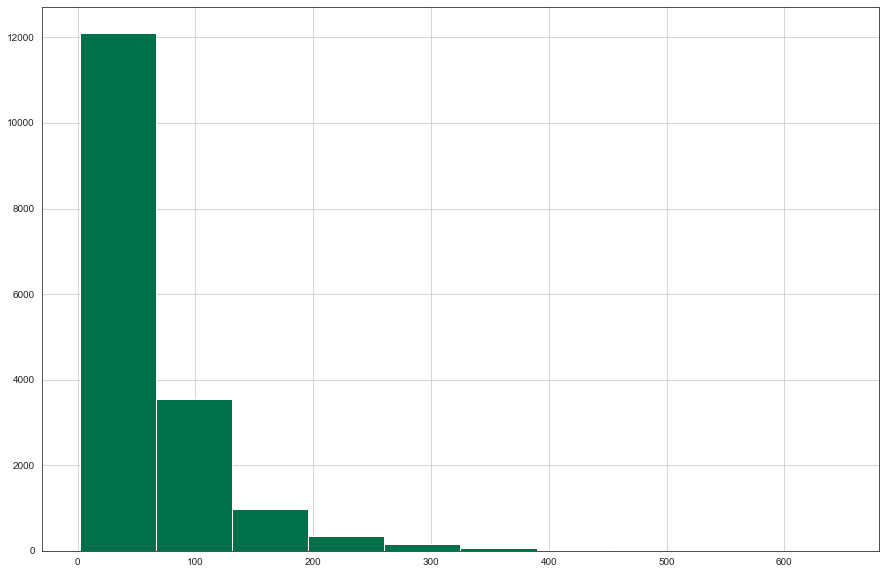

In [33]:
# Histogram of time_completed_viewed (log transformed)
starbucks.time_completed_viewed.hist(color = '#00704A')
# This looks better, almost the normal distribution

**Smote**

In [34]:
# Create a copy
starbucks_smote = starbucks.copy()

In [35]:
# Print
starbucks_smote.head()

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed
0,54.0,-0.178872,0,-0.639364,-0.310325,-1.844060,-0.880689,0.036974,0.302756,1.51035,1.0,1.0,1,1.0
2,120.0,-0.222823,1,0.912089,0.208567,-0.386243,-0.424613,-0.788151,0.302756,1.51035,1.0,1.0,1,1.0
5,54.0,-0.000723,0,1.866829,-1.017905,-1.876820,-0.880689,-0.229978,0.302756,1.51035,1.0,1.0,1,1.0
6,168.0,-0.007764,0,0.673404,1.246350,-0.042264,-0.880689,-1.426410,0.302756,1.51035,1.0,1.0,1,1.0
7,60.0,0.076510,0,0.076691,2.331306,0.449135,-0.880689,1.129052,0.302756,1.51035,1.0,1.0,1,1.0


Now we need a dataset, which has classification elements - 0 and 1.

The problem here - this decision is quiet arbitrary, we have tremendous outliers on both sides of our dataset.

So how to assign 1 and 0, how many rows to select?

I would try to make a decision, based on quantiles

In [36]:
# Check quantiles
starbucks_smote.quantile([.1, .25, .5, .95], axis = 0) 

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed
0.10,6.0,-0.382624,0.0,-1.415090,-1.348109,-1.713020,-0.880689,-1.113348,-1.099438,-1.238817,1.0,1.0,1.0,1.0
0.25,18.0,-0.272374,0.0,-0.639364,-0.734873,-0.861262,-0.652651,-0.805139,-0.538560,-1.238817,1.0,1.0,1.0,1.0
0.50,42.0,-0.130441,1.0,0.017020,-0.074465,0.121536,-0.196575,-0.188722,0.302756,-0.139150,1.0,1.0,1.0,1.0
0.95,168.0,0.544380,1.0,1.628144,1.812414,1.333653,0.943615,2.086804,3.107143,1.510350,1.0,1.0,1.0,1.0


In [37]:
# Now I would like to split the dataframe into two parts
starbucks0 = starbucks_smote[starbucks_smote.time_completed_viewed < 168]
starbucks1 = starbucks_smote[starbucks_smote.time_completed_viewed >= 168]

In [38]:
# Print dimensions
print(starbucks0.shape)
print(starbucks1.shape)

(16344, 14)
(884, 14)


In [39]:
# Now we need to assign 0 and 1 to these columns
starbucks0['label'] = 0
starbucks1['label'] = 1

C:\Users\oleks\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\oleks\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
# Check new columns
print(starbucks0.head(2))
print(starbucks1.head(2))

   time_completed_viewed    amount  male       age    income  viewed_time  \
0                   54.0 -0.178872     0 -0.639364 -0.310325    -1.844060   
2                  120.0 -0.222823     1  0.912089  0.208567    -0.386243   

   total_reward  membership_days  difficulty  duration  transaction  \
0     -0.880689         0.036974    0.302756   1.51035          1.0   
2     -0.424613        -0.788151    0.302756   1.51035          1.0   

   offer_viewed  offer_received  offer_completed  label  
0           1.0               1              1.0      0  
2           1.0               1              1.0      0  
    time_completed_viewed    amount  male       age    income  viewed_time  \
6                   168.0 -0.007764     0  0.673404  1.246350    -0.042264   
18                  384.0  0.778652     0  1.031432  0.491599    -1.844060   

    total_reward  membership_days  difficulty  duration  transaction  \
6      -0.880689        -1.426410    0.302756   1.51035          1.0   
1

In [41]:
# Now we need to rbind() two dataframes
starbucks_smoted = starbucks0.append(starbucks1)

In [42]:
# Dimensions
starbucks_smoted.shape
# We can see that now we have the same dataframe but with different classes assigned

(17228, 15)

In [43]:
# Print
starbucks_smoted.head()

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed,label
0,54.0,-0.178872,0,-0.639364,-0.310325,-1.844060,-0.880689,0.036974,0.302756,1.51035,1.0,1.0,1,1.0,0
2,120.0,-0.222823,1,0.912089,0.208567,-0.386243,-0.424613,-0.788151,0.302756,1.51035,1.0,1.0,1,1.0,0
5,54.0,-0.000723,0,1.866829,-1.017905,-1.876820,-0.880689,-0.229978,0.302756,1.51035,1.0,1.0,1,1.0,0
7,60.0,0.076510,0,0.076691,2.331306,0.449135,-0.880689,1.129052,0.302756,1.51035,1.0,1.0,1,1.0,0
8,36.0,0.215189,1,-0.341007,0.821802,1.399173,-0.880689,-0.637687,0.302756,1.51035,1.0,1.0,1,1.0,0


**2. Modelling**

**2.1. Decision tree**

In [94]:
# Split data
y = starbucks_smoted.iloc[:, -1]
X = starbucks_smoted.drop('label', axis = 1)

# Print y
y.head(5)

0    0
2    0
5    0
7    0
8    0
Name: label, dtype: int64

In [95]:
# Count labels by type
counter = Counter(y)
print(counter)

Counter({0: 16344, 1: 884})


In [96]:
# Transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [97]:
 # Print the oversampled dataset
counter = Counter(y)
print(counter)

Counter({0: 16344, 1: 16344})


In [98]:
# Save as csv
# days_smote = pd.DataFrame(X)
# days_smote['label'] = y
# days_smote.to_csv('days_smote.csv')

In [48]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [49]:
dtr = DecisionTreeRegressor(max_depth=10)

# fit data to the model
dtr.fit(X_train, y_train)

# Compute y_pred
dtr_y_pred = dtr.predict(X_test)

# Compute mse_dt
mse_dtr = MSE(y_test, dtr_y_pred)

# Compute rmse_dt
rmse_dtr = mse_dtr**(1/2)

# Print rmse_dt
print("Test set RMSE of Decision Tree Regression: {:.5f}".format(rmse_dtr))

# Compute the array containing the 10-folds CV MSEs
dtr_MSE_CV_scores = - cross_val_score(dtr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
dtr_RMSE_CV = (dtr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from decision tree regression: {:.5f}'.format(dtr_RMSE_CV))

# Fit dt to the training set
dtr.fit(X_train, y_train)

# Predict the labels of the training set
dtr_y_pred_train = dtr.predict(X_train)

# Evaluate the training set RMSE of dt
dtr_RMSE_train = (MSE(y_train, dtr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from decision tree regression: {:.5f}'.format(dtr_RMSE_train))

Test set RMSE of Decision Tree Regression: 0.00000
CV RMSE from decision tree regression: 0.00618
Train RMSE from decision tree regression: 0.00000


**2.2. Random Forest**

In [50]:
# Set seed for reproducibility
SEED = 1

# Split dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size = 0.2,
random_state = SEED)

# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestRegressor(n_estimators = 400,
min_samples_leaf = 0.1,
random_state = SEED)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)
# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)
y_pred_train=rf.predict(X_train)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.5f}'.format(rmse_test))
print('Train set RMSE of rf: {:.5f}'.format(rmse_train))

# Compute the array containing the 10-folds CV MSEs
rf_MSE_CV_scores = - cross_val_score(rf, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

rf_RMSE_CV = (rf_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from random forest regression: {:.5f}'.format(rf_RMSE_CV))

Test set RMSE of rf: 0.00000
Train set RMSE of rf: 0.00233
CV RMSE from random forest regression: 0.00618


**2.3. Gradient Boosting**

In [51]:
# Instantiate gb
gb = GradientBoostingRegressor(# max_depth = 10,
                               n_estimators = 400,
                               random_state = 1)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred_Gboost = gb.predict(X_test)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute RMSE

rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)

# Print the test set RMSE
print('Test set RMSE of gb: {:.5f}'.format(rmse_test))
print('Train set RMSE of gb: {:.5f}'.format(rmse_train))

# Compute the array containing the 10-folds CV MSEs
gb_MSE_CV_scores = - cross_val_score(gb, X_train, y_train, cv = 10, 
                                  scoring = 'neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
gb_RMSE_CV = (gb_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from Gradient Boosting Regression: {:.5f}'.format(gb_RMSE_CV))

Test set RMSE of gb: 0.00000
Train set RMSE of gb: 0.00233
CV RMSE from Gradient Boosting Regression: 0.00618


**2.4. SVM**

In [52]:
# Build the model
svr = SVR()

# fit data to the model
svr.fit(X_train, y_train)

# Compute y_pred
svr_y_pred = svr.predict(X_test)

# Compute mse_svr
mse_svr = MSE(y_test, svr_y_pred)

# Compute rmse_svr
rmse_svr = mse_svr**(1/2)

# Print rmse_dt
print("Test set RMSE of Support Vector Regression: {:.5f}".format(rmse_svr))

# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
svr_MSE_CV_scores = - cross_val_score(svr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
# Compute the 10-folds CV RMSE
svr_RMSE_CV = (svr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from Support Vector Regression: {:.5f}'.format(svr_RMSE_CV))

# Predict the labels of the training set
svr_y_pred_train = svr.predict(X_train)

# Evaluate the training set RMSE of dt
svr_RMSE_train = (MSE(y_train, svr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from Support Vector Regression: {:.5f}'.format(svr_RMSE_train))

Test set RMSE of Support Vector Regression: 0.12128
CV RMSE from Support Vector Regression: 0.11838
Train RMSE from Support Vector Regression: 0.11827


**2.5. KNN**

In [53]:
# Build the model
knn = KNeighborsRegressor()

# fit data to the model
knn.fit(X_train, y_train)

# Compute y_pred
knn_y_pred = knn.predict(X_test)

# Compute mse_knn
mse_knn = MSE(y_test, knn_y_pred)

# Compute rmse_knn
rmse_knn = mse_knn**(1/2)

# Print rmse_dt
print("Test set RMSE of k-nearest neighbors Regression: {:.5f}".format(rmse_knn))

# CV RMSE validation
# Compute the array containing the 10-folds CV MSEs
knn_MSE_CV_scores = - cross_val_score(knn, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
knn_RMSE_CV = (knn_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from k-nearest neighbors regression: {:.5f}'.format(knn_RMSE_CV))

# Predict the labels of the training set
knn_y_pred_train = knn.predict(X_train)

# Evaluate the training set RMSE of dt
knn_RMSE_train = (MSE(y_train, knn_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from k-nearest neighbors Regression: {:.5f}'.format(knn_RMSE_train))

Test set RMSE of k-nearest neighbors Regression: 0.00989
CV RMSE from k-nearest neighbors regression: 0.01092
Train RMSE from k-nearest neighbors Regression: 0.00830


**2.6. AdaBoost**

In [54]:
# Build the model
abr = AdaBoostRegressor(base_estimator=dtr, n_estimators=180)

# fit data to the model
abr.fit(X_train, y_train)

# Compute y_pred
abr_y_pred = abr.predict(X_test)

# Compute mse_abr
mse_abr = MSE(y_test, abr_y_pred)

# Compute rmse_abr
rmse_abr = mse_abr**(1/2)

# Print rmse_dt
print("Test set RMSE of Ada Boost Regression: {:.5f}".format(rmse_abr))

# Compute the array containing the 10-folds CV MSEs
abr_MSE_CV_scores = - cross_val_score(abr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
abr_RMSE_CV = (abr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from Ada Boost Regression: {:.5f}'.format(abr_RMSE_CV))

# Predict the labels of the training set
abr_y_pred_train = abr.predict(X_train)

# Evaluate the training set RMSE of dt
abr_RMSE_train = (MSE(y_train, abr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from Ada Boost Regression: {:.5f}'.format(abr_RMSE_train))

Test set RMSE of Ada Boost Regression: 0.00000
CV RMSE from Ada Boost Regression: 0.00618
Train RMSE from Ada Boost Regression: 0.00000


**3. Conclusion and interpretation of results**

After training, testing, and cross validating six models, we receive good and consistent results. 

| Algorithm | Train RMSE | Test RMSE | CV RMSE |
| --- | --- | --- | --- |
| Decision Tree | 0.00000 | 0.00000 | 0.00618  |
| Random Forest | 0.00233 | 0.00000 | 0.00618  |
| Gradient Boosting | 0.00223 | 0.00000 | 0.00618 |
| SVM | 0.11827 | 0.12128 | 0.11838 |
| KNN | 0.00830 | 0.00989 | 0.01092 |
| Ada Boosting | 0.00000 | 0.00000 | 0.00618 |

We started from the approach that **our dependent variable was log-transformed**. 

Hence, it must be interpreted, using the following approach:

Source: https://stats.stackexchange.com/questions/18480/interpretation-of-log-transformed-predictor-and-or-response

`log(Y) = Intercept + B1 * X + Error`

`One unit increase in X is associated with a (B1 * 100) percent increase in Y.`

But after applying `SMOTE()`, we achieved good and consistent results (above). 

**Why predicting this variable is important?**

Being able to predict this variable `time_completed_viewed`, we will be able to target certaing customers additionally (or not not bother them). For example, if we can predict the time difference and some customers take much more time, we can send them one more reminder. At the same time, we will not bother other customers, who are expected to complete offer soon and annoy them with additional spam.

**4. PyCaret Regression**

Source: https://github.com/pycaret/pycaret/blob/master/examples/PyCaret%202%20Regression.ipynb

In [99]:
# Read clean data
starbucks_days = pd.read_csv('days_smote.csv')

# Print
starbucks_days.head()

,Unnamed: 0,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration,transaction,offer_viewed,offer_received,offer_completed,label
0,0,54.0,-0.178872,0,-0.639364,-0.310325,-1.844060,-0.880689,0.036974,0.302756,1.51035,1.0,1.0,1,1.0,0
1,1,120.0,-0.222823,1,0.912089,0.208567,-0.386243,-0.424613,-0.788151,0.302756,1.51035,1.0,1.0,1,1.0,0
2,2,54.0,-0.000723,0,1.866829,-1.017905,-1.876820,-0.880689,-0.229978,0.302756,1.51035,1.0,1.0,1,1.0,0
3,3,60.0,0.076510,0,0.076691,2.331306,0.449135,-0.880689,1.129052,0.302756,1.51035,1.0,1.0,1,1.0,0
4,4,36.0,0.215189,1,-0.341007,0.821802,1.399173,-0.880689,-0.637687,0.302756,1.51035,1.0,1.0,1,1.0,0


In [100]:
# Drop a column
starbucks_days = starbucks_days.drop(['Unnamed: 0'], axis = 1)

In [101]:
# Drop a column
starbucks_days = starbucks_days.drop(['transaction', 'offer_viewed', 'offer_received', 'offer_completed'], axis = 1)

In [102]:
# Drop a column
starbucks_days = starbucks_days.drop(['label'], axis = 1)

In [87]:
# Print
starbucks_days.head()

,time_completed_viewed,amount,male,age,income,viewed_time,total_reward,membership_days,difficulty,duration
0,54.0,-0.178872,0,-0.639364,-0.310325,-1.844060,-0.880689,0.036974,0.302756,1.51035
1,120.0,-0.222823,1,0.912089,0.208567,-0.386243,-0.424613,-0.788151,0.302756,1.51035
2,54.0,-0.000723,0,1.866829,-1.017905,-1.876820,-0.880689,-0.229978,0.302756,1.51035
3,60.0,0.076510,0,0.076691,2.331306,0.449135,-0.880689,1.129052,0.302756,1.51035
4,36.0,0.215189,1,-0.341007,0.821802,1.399173,-0.880689,-0.637687,0.302756,1.51035


In [103]:
# Check types
starbucks_days.dtypes

time_completed_viewed    float64
amount                   float64
male                       int64
age                      float64
income                   float64
viewed_time              float64
total_reward             float64
membership_days          float64
difficulty               float64
duration                 float64
dtype: object

In [104]:
type(starbucks_days)

pandas.core.frame.DataFrame

In [105]:
starbucks_days['time_completed_viewed'].value_counts()

6.000000      1682
12.000000     1503
18.000000     1318
24.000000     1212
174.000000    1068
              ... 
444.107530       1
226.213225       1
411.947513       1
236.001744       1
394.722944       1
Name: time_completed_viewed, Length: 3572, dtype: int64